In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.utils import resample

# Load the datasets
train_transaction = pd.read_csv('train_transaction.csv')
test_transaction = pd.read_csv('test_transaction.csv')
train_identity = pd.read_csv('train_identity.csv')
test_identity = pd.read_csv('test_identity.csv')

/home/datascience/.local/lib/python3.8/site-packages/scipy/__init__.py:143: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.17.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Merge the datasets on TransactionID
train_data = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test_data = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

# Display the first few rows of the merged datasets
print(train_data.head())
print(test_data.head())

print("Size of train data:", train_data.shape)
print("Size of test data:", test_data.shape)

# Check for missing values
print("Missing values in train data:", train_data.isnull().sum().sum())
print("Missing values in test data:", test_data.isnull().sum().sum())

   TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5  ...                id_31  id_32  \
0    NaN  150.0    discover  142.0  ...                  NaN    NaN   
1  404.0  150.0  mastercard  102.0  ...                  NaN    NaN   
2  490.0  150.0        visa  166.0  ...                  NaN    NaN   
3  567.0  150.0  mastercard  117.0  ...                  NaN    NaN   
4  514.0  150.0  mastercard  102.0  ...  samsung browser 6.2   32.0   

       id_33           id_34  id_35 id_36 id_37  id_38  DeviceType  \
0        NaN             NaN    NaN   Na

In [3]:
# Define features and target
X = train_data.drop(columns=['isFraud', 'TransactionID'])
y = train_data['isFraud']

# Handle categorical variables and missing values using a pipeline
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Apply undersampling to balance the dataset
fraud = train_data[train_data['isFraud'] == 1]
non_fraud = train_data[train_data['isFraud'] == 0]

non_fraud_downsampled = resample(non_fraud,
                                 replace=False,
                                 n_samples=len(fraud),
                                 random_state=42)

train_data_balanced = pd.concat([fraud, non_fraud_downsampled])

X_balanced = train_data_balanced.drop(columns=['isFraud', 'TransactionID'])
y_balanced = train_data_balanced['isFraud']

# Split the balanced data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

In [4]:
# Create and train the pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))])

model.fit(X_train, y_train)

/home/datascience/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5',
       'addr1', 'addr2', 'dist1', 'dist2',
       ...
       'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_24', 'id_25',
       'id_26', 'id_32'],...
                                                                                 sparse=False))]),
                                                  Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1',
       'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15',
       'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33',
       'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType',
       'DeviceInfo'],
      dtype='object'))])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [5]:
# Evaluate the model
y_pred = model.predict(X_val)
y_pred_proba = model.predict_proba(X_val)[:, 1]

conf_matrix = confusion_matrix(y_val, y_pred)
class_report = classification_report(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_proba)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)
print("\nROC AUC Score:", roc_auc)

Confusion Matrix:
[[3603  530]
 [ 685 3448]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      4133
           1       0.87      0.83      0.85      4133

    accuracy                           0.85      8266
   macro avg       0.85      0.85      0.85      8266
weighted avg       0.85      0.85      0.85      8266


ROC AUC Score: 0.9283841896430733


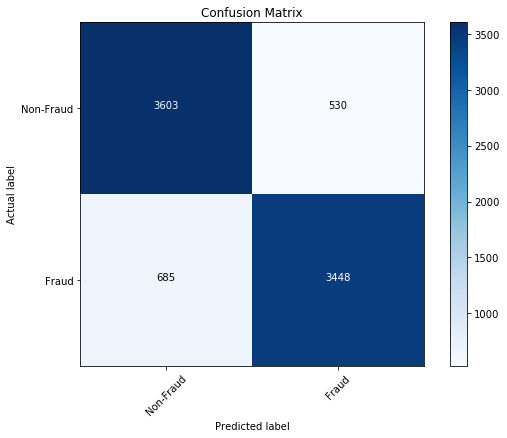

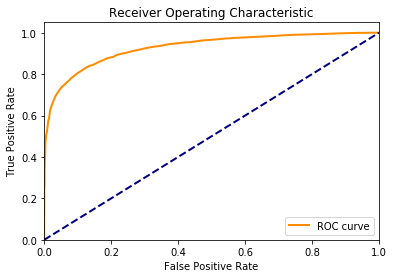

In [6]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Non-Fraud', 'Fraud'], rotation=45)
plt.yticks(tick_marks, ['Non-Fraud', 'Fraud'])
plt.tight_layout()
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

thresh = conf_matrix.max() / 2.
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Process the test data
X_test = test_data.drop(columns=['TransactionID'])

# Predict on the test data
test_predictions = model.predict(X_test)

# Save the predictions to a CSV file
submission = pd.DataFrame({
    'TransactionID': pd.read_csv('test_transaction.csv')['TransactionID'],
    'isFraud': test_predictions
})
submission.to_csv('submission.csv', index=False)